In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (17, 8)
import pandas as pd
import networkx as nx

%matplotlib inline

import scanpy as sc
import seaborn as sns
import scipy.stats as stats

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Overview of project

The end goal of this summer (2022) long project is to identify genes that are poorly knocked down by CRISPRi. This analysis uses data obtained from (Replogle et al., 2022) https://www.sciencedirect.com/science/article/pii/S0092867422005979?via%3Dihub

By identifying and having a referential/curated list of these genes, further experiments within the epigenetic subgroup of the Weissman Lab to test the effectiveness of potential epigenetic editing tools can be aided. It is also our hope that other scientific researchers who find this list useful can make good use of it in their own experiments.

At the time of this analysis, I am working on identifying the potential of a 'CRISPR-HUSH' silencing tool which would hypothetically replace the KRAB domain in the CRISPRi dCas9-KRAB structure with the HUSH complex, or more accurately and realistically stated, one of the three components of the HUSH complex (PPHLN, TASOR or MPP8).

HUSH:
https://www.nature.com/articles/s41586-021-04228-1, https://www.science.org/doi/10.1126/science.aaa7227

# 1) Importing single cell data

In this analysis, I work with normalized single cell and bulk RNA seq data. All data is from experiments involving the k562 cell line. The bulk data will be talked about in a future section but here, the single cell data (K562_gwps_normalized_singlecell_01.h5ad) is imported as an anndata file, where the vars and obs matrix metadata makes subsetting to find data pertaining to every perturbation and to every cell easier to do. 

A note on anndata:
https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata

vars_matrix: data describing the actual genes that we’re targeting across cells; metadata for the columns (gene_id is the main column) 

obs_matrix: data describing the genetic perturbations per cell (silencing of the gene) which are the rows (main column is the cell_barcode) 


In [2]:
anndata_file = '/lab/solexa_weissman/victory/gwps/K562_gwps_normalized_singlecell_01.h5ad'

single_cell = sc.read_h5ad(anndata_file)
obs_matrix = single_cell.obs
var_matrix = single_cell.var

#quicker import from csv to prevent loading time of large anndata file
obs_matrix = pd.read_csv('/lab/solexa_weissman/victory/gwps/sc_obs_matrix.csv')
var_matrix = pd.read_csv('/lab/solexa_weissman/victory/gwps/sc_var_matrix.csv')

display(obs_matrix.head())
display(var_matrix.head())

,cell_barcode,gem_group,gene,gene_id,transcript,gene_transcript,sgID_AB,mitopercent,UMI_count,z_gemgroup_UMI,core_scale_factor,core_adjusted_UMI_count
0,AAACCCAAGAAACCAT-157,157,CTSC,ENSG00000109861,P1P2,1946_CTSC_P1P2_ENSG00000109861,CTSC_-_88070848.23-P1P2|CTSC_-_88070918.23-P1P2,0.088177,14709.0,0.470687,1.051176,13992.900
1,AAACCCAAGAAACCAT-207,207,CWC25,ENSG00000273559,P1P2,1973_CWC25_P1P2_ENSG00000273559,CWC25_+_36981555.23-P1P2|CWC25_+_36981567.23-P1P2,0.114342,16162.0,0.824790,1.074744,15038.005
2,AAACCCAAGAAACCAT-29,29,PDE4DIP,ENSG00000178104,ENST00000313431.9,6168_PDE4DIP_ENST00000313431.9_ENSG00000178104,PDE4DIP_+_144932474.23-ENST00000313431.9|PDE4D...,0.107157,33297.0,2.627126,1.472444,22613.424
3,AAACCCAAGAAAGCGA-149,149,ZZEF1,ENSG00000074755,P1P2,10745_ZZEF1_P1P2_ENSG00000074755,ZZEF1_+_4046247.23-P1P2|ZZEF1_+_4046255.23-P1P2,0.143107,7435.0,0.918149,0.480401,15476.670
4,AAACCCAAGAAATCCA-172,172,SNAPIN,ENSG00000143553,P1P2,8210_SNAPIN_P1P2_ENSG00000143553,SNAPIN_+_153631238.23-P1P2|SNAPIN_-_153631252....,0.130754,7755.0,-0.230920,0.695649,11147.856


,gene_id,gene_name,chr,start,end,class,strand,length,in_matrix,mean,std,cv,fano
0,ENSG00000237491,LINC01409,chr1,778747,810065,gene_version10,+,31318,True,0.116626,0.349971,3.000803,1.050194
1,ENSG00000228794,LINC01128,chr1,825138,868202,gene_version9,+,43064,True,0.182850,0.437275,2.391434,1.045713
2,ENSG00000188976,NOC2L,chr1,944203,959309,gene_version11,-,15106,True,1.415674,1.397208,0.986957,1.378984
3,ENSG00000187961,KLHL17,chr1,960584,965719,gene_version14,+,5135,True,0.105599,0.330678,3.131439,1.035497
4,ENSG00000188290,HES4,chr1,998962,1000172,gene_version10,-,1210,True,0.242700,0.550596,2.268630,1.249098


test code for imports:

In [3]:
obs_matrix[(obs_matrix['gem_group']==1) & (obs_matrix['gene']=='non-targeting')].sort_values('gene_transcript')

var_matrix.sort_values('gene_name')
#var_matrix does not take gene transcript into account because genes don't have duplicates here
#implies control_expression values were limited to average between transcripts?

var_matrix[var_matrix['gene_name']== 'MARS2']
#MARS2 is an example of a gene that exists in the obs_matrix but not in the var_matrix

,gene_id,gene_name,chr,start,end,class,strand,length,in_matrix,mean,std,cv,fano


Notes/Summary from Section:
- There are cases in some cells where there are multiple promoters targeted, noticeable from the fact that some genes are repeated in the dat and so have more than one transcript (identifiable by P1 or P2 where 'P' means promoter)
- Every promoter is targeted by a pair of guides


# 2) Mapping distribution of a gene across single cells
In this section, I play around with the single cell h5ad file to better understand the data that I am working with. I created functions that can plot histograms of the perturbed cells for any given gene or gene transcript (important for cases where more than one promoter is targetted) in order to visually see what kind of distributions are common and different. 

A subset of the unperturbed cells (cells with guides that are non-targetting) are also plotted side-by-side with the perturbed cells to see if there is any significant difference/shift between both distributions. 

In [71]:
def plot_hist(gene):
    ko_subset = obs_matrix[(obs_matrix['gene']== gene)]
    wt_total = obs_matrix[(obs_matrix['gene']== 'non-targeting')]
    
    cell_barcodes_ko = obs_matrix.index[obs_matrix['gene'] == gene].tolist()
    cell_barcodes_wt = wt_total.index[wt_total['gene'] == 'non-targeting'].tolist()
    
    gene_id = var_matrix.index[var_matrix['gene_name'] == gene].tolist()
    try:
        genes_subset_ko = single_cell[cell_barcodes_ko, gene_id]
    except ValueError:
        print ("gene does not exist in var_matrix; only found in obs_matrix")
    genes_subset_wt = single_cell[np.random.choice(cell_barcodes_wt, len(ko_subset)), gene_id]

    try:
        ko_expression_array = np.array (genes_subset_ko.X)
    except IndexError:
        print ("gene does not exist in var_matrix; only found in obs_matrix")    
        
    bins = int(len(ko_subset)/6)
    wt_expression_array = np.array (genes_subset_wt.X)
    
    plt.title(gene)
    plt.hist (ko_expression_array, bins = bins, color = 'darkviolet', label = 'ko', alpha = 0.5, ec='black')
    plt.hist (wt_expression_array, bins = bins, color = 'darkgrey', label = 'wt', alpha = 0.5, ec= 'black')
    plt.legend()
    plt.xlabel('Expression')
    plt.ylabel('Normalized Count')
    plt.yscale('log')
    plt.show()
    
    print ("Number of cells with", gene, "perturbation:", len (ko_subset))

In [5]:
def plot_hist_transcript(gene_transcript):
    ko_subset = obs_matrix[(obs_matrix['gene_transcript']== gene_transcript)]
    wt_total = obs_matrix[(obs_matrix['gene']== 'non-targeting')]
    
    cell_barcodes_ko = obs_matrix.index[obs_matrix['gene_transcript'] == gene_transcript].tolist()
    
    cell_barcodes_wt = wt_total.index[wt_total['gene'] == 'non-targeting'].tolist()
    
    gene_name_trans = obs_matrix.gene[obs_matrix['gene_transcript'] == gene_transcript].tolist()[0]
    gene_id = var_matrix.index[var_matrix['gene_name'] == gene_name_trans].tolist()
    try:
        genes_subset_ko = single_cell[cell_barcodes_ko, gene_id]
    except ValueError:
        print ("gene does not exist in var_matrix; only found in obs_matrix")
    genes_subset_wt = single_cell[np.random.choice(cell_barcodes_wt, len(ko_subset)), gene_id]

    try:
        ko_expression_array = np.array (genes_subset_ko.X)
    except IndexError:
        print ("gene does not exist in var_matrix; only found in obs_matrix")    

    wt_expression_array = np.array (genes_subset_wt.X)
    
    
    plt.title(gene_transcript)
    bins = int(len(ko_subset)/6)
    plt.hist (ko_expression_array, bins = bins, color = 'darkviolet', label = 'ko', alpha = 0.5, ec='black')
    plt.hist (wt_expression_array, bins = bins, color = 'darkgrey', label = 'wt', alpha = 0.5, ec= 'black')
   
    plt.legend()
    plt.xlabel('Expression')
    plt.ylabel('Normalized Count')
    plt.yscale('log')
    plt.show()

    print ("Number of cells with", gene_transcript, "(promoter-specific) perturbation:", len (ko_subset))

test code for distribution mapping/for troubleshooting:

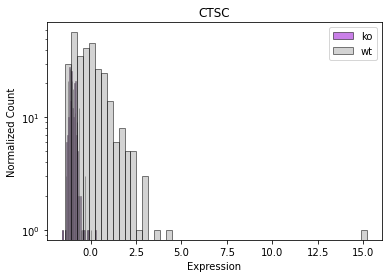

Number of cells with CTSC perturbation: 306


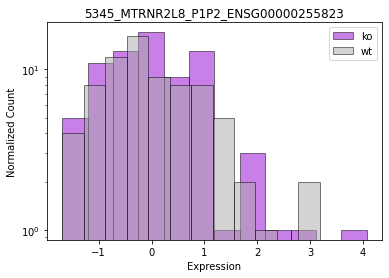

Number of cells with 5345_MTRNR2L8_P1P2_ENSG00000255823 (promoter-specific) perturbation: 75


In [72]:
gene = 'CTSC'
gene_transcript = '5345_MTRNR2L8_P1P2_ENSG00000255823'
plot_hist (gene)
plot_hist_transcript (gene_transcript)


wt_total = obs_matrix[(obs_matrix['gene']== 'non-targeting')]
#75,000 non-targeting in total woah

# cell_barcodes_ko = obs_matrix.index[obs_matrix['gene'] == gene].tolist()
# cell_barcodes_wt = wt_subset.index[wt_subset['gene'] == 'non-targeting'].tolist()
# cell_barcodes_ko
# cell_barcodes_wt

# gene_id = var_matrix.index[var_matrix['gene_name'] == gene].tolist()
# gene_id

# sns.histplot(np.linspace(0,100,100), bins = 100, color = 'purple', label = 'ko', stat = 'count')
#seaborn colors show up here perfectly but not when plotting actual dataset?

Notes/Summary from Section:
- The cell barcode acts as the index which makes sense; was initially expecting integers which confused me a bit at first.
- For some reason, the seaborn plotting package wasn't working for me so had to dip back to matplotlib.
- Difference in number of bins is proportional to the number of cells that had the given perturbation; so in the case of CTSC and MTRNR2L8 genes, CTSC has 306 genes where the latter had 75, hence the difference in spread. 
- From plotting random genes, we see that there are cases where there is a notable overlap between the purple (pertubed cells) and grey (non-targetting control cells) distributions and other cases where there is almost no overlap with a significant shift of the perturbed cells to the left (toward -1).
- A smart interpretation of the above observation would be that where there is a shift, there is good knockdown of the targetted gene. Further analysis of bulk data and using metrics like p-values, fold_expr and pct_expr will help to verify this.

# 3) Importing and cleaning up bulk data (and sc data)

In this section, to further understand our data, I import data that summarizes results for each perturbation across multiple cells, rather than on a single cell level. 

- K562_gwps_normalized_bulk_01.h5ad (anndata with vars and obs that can be used to subset data to find average knockdown across all cells for a given gene transcript)
    - obs_matrix has super useful information which forms the basis of almost all analysis done going forward (notable columns will be defined subsequently)

- K562_gwps_guide_library.parquet (very important information about the guides used to target each gene promoter ; allows us to map each gene transcript to the targeting sequences of the guides and the guide ID!)


In [7]:
bulk_h5ad = '/lab/solexa_weissman/victory/gwps/K562_gwps_normalized_bulk_01.h5ad'
guides_parquet = '/lab/solexa_weissman/victory/gwps/K562_gwps_guide_library.parquet'
bulk_data = sc.read_h5ad(bulk_h5ad)
df_guides = pd.read_parquet(guides_parquet)

bulk_obs = bulk_data.obs
bulk_var = bulk_data.var

display(bulk_obs.head())
display(bulk_var.head())
display(df_guides.head())

,UMI_count_unfiltered,num_cells_unfiltered,num_cells_filtered,control_expr,fold_expr,pct_expr,core_control,mean_leverage_score,std_leverage_score,energy_test_p_value,anderson_darling_counts,mann_whitney_counts,z_gemgroup_UMI,mitopercent,TE_ratio,cnv_score_z
gene_transcript,,,,,,,,,,,,,,,,
0_A1BG_P1_ENSG00000121410,11648.256836,246,237.0,0.171285,0.023274,-0.976726,False,0.264768,1.137824,0.017798,3,4,0.088383,0.118743,0.013627,NaN
10000_ZBTB46_P1P2_ENSG00000130584,12291.757812,95,89.0,0.026212,0.000000,-1.000000,False,0.260951,1.095702,0.130587,1,1,0.339968,0.116354,0.014563,7.305249
10001_ZBTB47_P1P2_ENSG00000114853,11295.581055,318,308.0,0.048150,0.527716,-0.472284,False,0.277062,1.115502,0.457854,0,0,0.044135,0.118609,0.014196,0.014276
10002_ZBTB48_P1P2_ENSG00000204859,12323.345703,84,83.0,0.134619,0.163264,-0.836736,False,0.370545,1.089380,0.352665,3,3,0.241949,0.115377,0.013690,0.881662
10003_ZBTB49_P1P2_ENSG00000168826,11520.527344,290,276.0,0.026936,0.127473,-0.872527,False,0.301086,1.099432,0.217678,1,1,0.135962,0.119273,0.014122,1.277506


,gene_name,mean,std,cv,in_matrix,gini,clean_mean,clean_std,clean_cv
gene_id,,,,,,,,,
ENSG00000237491,LINC01409,0.114359,0.033798,0.295547,True,0.153642,0.117205,0.034833,0.297200
ENSG00000228794,LINC01128,0.178166,0.040590,0.227822,True,0.122999,0.182778,0.041933,0.229419
ENSG00000188976,NOC2L,1.375142,0.162536,0.118196,True,0.063150,1.411069,0.164344,0.116468
ENSG00000187961,KLHL17,0.102961,0.030863,0.299751,True,0.162265,0.105230,0.031627,0.300552
ENSG00000188290,HES4,0.237189,0.057237,0.241315,True,0.127442,0.242638,0.058972,0.243044


,unique sgRNA pair ID,gene,transcript,ensembl gene id,sgID_A,targeting sequence A,sgID_B,targeting sequence B,duplicated guide pair?,either guide duplicated?
0,0_A1BG_P1_ENSG00000121410,A1BG,P1,ENSG00000121410,A1BG_+_58858964.23-P1,GCTCCGGGCGACGTGGAGTG,A1BG_-_58858788.23-P1,GGGGCACCCAGGAGCGGTAG,False,False
1,1_A1BG_P2_ENSG00000121410,A1BG,P2,ENSG00000121410,A1BG_-_58864840.23-P2,GCCGGTGCAGTGAGTGTCTG,A1BG_-_58864822.23-P2,GATGATGGTCGCGCTCACTC,False,False
2,2_AAAS_P1P2_ENSG00000094914,AAAS,P1P2,ENSG00000094914,AAAS_-_53715438.23-P1P2,GAGGACGAGTACGCGGTCCC,AAAS_+_53715355.23-P1P2,GCCTCGCCGTTTGTCCCTTG,False,False
3,3_AACS_P1P2_ENSG00000081760,AACS,P1P2,ENSG00000081760,AACS_+_125549983.23-P1P2,GCGGCGGCGGCGGGGAACAA,AACS_-_125550169.23-P1P2,GCCCGGTCGGGAGGAGATCC,False,False
4,4_PRXL2C_P1P2_ENSG00000158122,PRXL2C,P1P2,ENSG00000158122,AAED1_-_99417574.23-P1P2,GGCGCGGCCATGACGCGGGG,AAED1_+_99417525.23-P1P2,GCGGTCACGCGGCAGGTTAG,False,False


**A NOTE ON RELEVANT OBS MATRIX COLUMNS!!**

- **Dataset Column Descriptions** (note that the first three are averaged across cells; GW) 
    - **fold_expr**: fold knockdown of the target gene in cells with targeting sgRNAs compared to cells with non-targeting sgRNAs
        - mean_pop.cells['fold_expr'] = mean_pop.cells['expr']/mean_pop.cells['control_expr']
        - a fold increase is defined as the ratio of an increased number to the original number. For example, an original number of 15 and the final number of 30 would be a 2 fold increase (30/15=2) 
    - **pct_expr**: fraction knockdown of the target genes, where negative values indicate decreased expression compared to control cells.
        - mean_pop.cells['diff_expr'] = mean_pop.cells['expr'] - mean_pop.cells['control_expr']
mean_pop.cells['pct_expr'] = mean_pop.cells['diff_expr']/mean_pop.cells['control_expr']
        - Negative 1 is perfect knockdown
        - Negative .5: 50% of the mRNA remaining
    - **control_expr**:  
        - A control expression of 1 means that in each cell, there is just one corresponding mRNA allowing the gene that that gRNA targets to be expressed 
    - **Either guide duplicated**: a specific gRNA that targets more than one gene so can knockdown more than one gene
    - **Duplicated guide pair**: a pair of guides that **together** target more than one gene
    - pct_expr = fold_expr - 1
    - fold_expr - pct_expr = 1


In [16]:
# merging guide library with bulk data obs matrix so can have more complete info about knockdown (kd)
df_guides_new = df_guides.rename (columns = {'unique sgRNA pair ID': 'gene_transcript'})
bulk_merged = pd.merge (bulk_obs, df_guides_new, on = 'gene_transcript')

# streamlined & re-ordered version of merged table; getting rid of certain columns
stream = bulk_merged[['gene_transcript','ensembl gene id','gene','num_cells_filtered',
'control_expr','fold_expr','pct_expr','energy_test_p_value','targeting sequence A',
'sgID_A','targeting sequence B','sgID_B','duplicated guide pair?','either guide duplicated?',
'mann_whitney_counts','anderson_darling_counts','core_control','mean_leverage_score',
'std_leverage_score','UMI_count_unfiltered','z_gemgroup_UMI','mitopercent','TE_ratio',
'cnv_score_z']]

#all non-targetting guides
nt_subset = stream[stream["core_control"] == True]

#finding genes that show up across all single cell and bulk data sets 
#so we have a reliable/consistent dataset to work with

subset = stream[(stream["control_expr"] >= .1) 
                & (stream["core_control"] == False)& stream.gene.isin(var_matrix.gene_name)].sort_values('pct_expr', ascending = True)

subset = subset.rename(columns={'ensembl gene id': 'gene_ID'})
# control expr >=.1 because want genes that are at least normally (prior to kd)
#expressed in 1 out of every 10 cells so helps filter out noise

# got rid of num_cells_filtered threshold of 45 cells to account for it later on in analysis

display(subset.head())


,gene_transcript,gene_ID,gene,num_cells_filtered,control_expr,fold_expr,pct_expr,energy_test_p_value,targeting sequence A,sgID_A,...,mann_whitney_counts,anderson_darling_counts,core_control,mean_leverage_score,std_leverage_score,UMI_count_unfiltered,z_gemgroup_UMI,mitopercent,TE_ratio,cnv_score_z
11257,9_AAR2_P1P2_ENSG00000131043,ENSG00000131043,AAR2,93.0,0.174746,0.0,-1.0,0.000100,GTGGGGCGAGGCGGTGAGTG,AAR2_-_34824434.23-P1P2,...,377,652,False,1.423462,1.257388,10261.093750,-0.288654,0.098771,0.015879,3.219859
4999,4338_KHK_P1P2_ENSG00000138030,ENSG00000138030,KHK,127.0,0.107530,0.0,-1.0,0.860014,GGGACACGCGAGGTACAGCT,KHK_+_27309661.23-P1P2,...,0,0,False,0.106007,0.937160,12035.140625,0.092424,0.119292,0.013587,-0.714195
5021,4358_WASHC4_P1P2_ENSG00000136051,ENSG00000136051,WASHC4,117.0,0.259725,0.0,-1.0,0.007299,GCAGCCCCAACCAGCCCGTG,KIAA1033_+_105501533.23-P1P2,...,9,11,False,0.293196,1.088142,10449.625000,-0.108992,0.117534,0.013975,-1.062243
5035,4370_MFSD4B_P1P2_ENSG00000173214,ENSG00000173214,MFSD4B,181.0,0.290107,0.0,-1.0,0.039096,GAGCGGACCGCCCGGAACCG,KIAA1919_+_111580599.23-P1P2,...,13,12,False,0.163176,1.032218,11588.358398,0.039041,0.119694,0.013121,-0.005600
449,10407_ZNF510_P1P2_ENSG00000081386,ENSG00000081386,ZNF510,42.0,0.134806,0.0,-1.0,0.521748,GGCACCAGCAAACACTAACA,ZNF510_-_99540354.23-P1P2,...,1,1,False,0.264464,1.577160,10064.666992,-0.005547,0.121955,0.014231,2.090619


**to troubleshoot/test:**

In [31]:
bulk_genes = list(set(subset.gene))
bulk_gene_id = list(set(subset['gene_ID']))

#when we realized that genes were duplicated, because multiple promoters are targeted for some genes

bulk_genes_transcripts = list(set(subset['gene_transcript']))
print ("total nos unique genes after filtering across all datasets:", len (bulk_genes))
print ("total gene transcripts after filtering across all datasets:", len (bulk_genes_transcripts))
print ("total unique gene IDs after filtering across all datasets:", len (bulk_gene_id))
#why are there fewer gene IDs?

total nos unique genes after filtering across all datasets: 7553
total gene transcripts after filtering across all datasets: 8118
total unique gene IDs after filtering across all datasets: 7555


**Notes/Summary:**
- What value does the bulk anndata data store? Ans: the average gene expression value across all cells for that gene, subset by gene ID + gene transcript that match up with each other.
    - Example below: 
    bulk_data ['0_A1BG_P1_ENSG00000121410', 'ENSG00000121410']
- Every gene promoter is targeted by a pair of guides
- Some genes have more than one promoter so are targeted than more than one guide pair, hence earlier mentioned gene duplicate rows cuz multiple gene transcripts
- Expression values for bulk data are likely just averaged across promoters because var_matrix has unique genes only and doesn't account for gene transcripts

# 4) Calculating Mann-Whitney P-Values

While a number of the columns from the obs matrix of the bulk dataset provide useful information about the knocdown effect on each gene, we decided to calculate mann-Whitney p-values to provide another self-calculated metric for analyzing our data. 

Notable columns referenced in table for filtering data: control_expr, fold_expr, pct_expr, energy_test_p_value, num_cells_filtered & core_control

In [ ]:
stats.mannwhitneyu(ko_expression_array, wt_expression_array)[1]
#p-value less than 0.05 usually rejects the null hypothesis, i.e, allows us to assume 
#statistical significance; if higher though, safe to assume null hypothesis

p_values = []
rejects = []

def p_value(gene):
    ko_subset = obs_matrix[(obs_matrix['gene']== gene)]
    wt_total = obs_matrix[(obs_matrix['gene']== 'non-targeting')]
    wt_subset = wt_total.sample(len(ko_subset))
    
    cell_barcodes_ko = obs_matrix.index[obs_matrix['gene'] == gene].tolist()
    cell_barcodes_wt = wt_total.index[wt_total['gene'] == 'non-targeting'].tolist()
    
    gene_id = ko_subset['gene_id'][0]
    #gene_id = var_matrix.index[var_matrix['gene_name'] == gene].tolist()
    
    genes_subset_ko = single_cell[cell_barcodes_ko,[gene_id]]
    genes_subset_wt = single_cell[np.random.choice(cell_barcodes_wt, len(ko_subset)),[gene_id]]
    ko_expression_array = np.array (genes_subset_ko.X)
    wt_expression_array = np.array (genes_subset_wt.X)
    return stats.mannwhitneyu(ko_expression_array, wt_expression_array)[1]

In [32]:
p_values_transcripts = []
rejects_transcripts = []

def p_value_transcript (gene_transcript):
    ko_subset = obs_matrix[(obs_matrix['gene_transcript']== gene_transcript)]
    wt_total = obs_matrix[(obs_matrix['gene']== 'non-targeting')]
    cell_barcodes_ko = obs_matrix.index[obs_matrix['gene_transcript'] == gene_transcript].tolist()  
    cell_barcodes_wt = wt_total.index[wt_total['gene'] == 'non-targeting'].tolist()
    
    gene_id = ko_subset['gene_id'][0]
    genes_subset_ko = single_cell[cell_barcodes_ko,[gene_id]]
    genes_subset_wt = single_cell[cell_barcodes_wt,[gene_id]]
    
    ko_expression_array = np.array (genes_subset_ko.X)
    wt_expression_array = np.array (genes_subset_wt.X)
    return stats.mannwhitneyu(ko_expression_array, wt_expression_array)[1]

len (p_values_transcripts)
p_values_transcripts

[]

**Notes:**
- Had previously only used a subset of non-targetting control cells to calculate p-values (because wanted to reduce computing time) but that affected the accuracy of the values so did not subset the wt cells again.

# 5) Using p-values for plots + further analysis

In [ ]:
for gene_transcript in bulk_genes_transcripts:
    try:
        p_values_transcripts.append((p_value_transcript(gene_transcript)[0]))
    except KeyError:
        rejects_transcripts.append(gene)
    except IndexError:
        rejects_transcripts.append(gene)
len (p_values_transcripts)

In [39]:
#to fast track process of getting genes but actual code to get plot_table is below the following line
plot_table = pd.read_csv('/lab/solexa_weissman/victory/gwps/gwps_filtered_genes.csv')

In [ ]:
# make data frame out of gene transcripts and map to appropriate p-value
transcript_df = pd.DataFrame (bulk_genes_transcripts,columns = ['gene_transcript'])
transcript_df['whitt_p_values'] = p_values_transcripts
transcript_df

plot_table = subset

#recombining the wt and the ko and including mann whitney p-values too 
plot_table = pd.merge (plot_table, transcript_df, on = 'gene_transcript')
cols = list(plot_table.columns.values)

plot_table = plot_table[['gene_transcript','gene_ID','gene','whitt_p_values','num_cells_filtered',
'control_expr','fold_expr','pct_expr','energy_test_p_value','targeting sequence A',
'sgID_A','targeting sequence B','sgID_B','duplicated guide pair?','either guide duplicated?',
'mann_whitney_counts','anderson_darling_counts','core_control','mean_leverage_score',
'std_leverage_score','UMI_count_unfiltered','z_gemgroup_UMI','mitopercent','TE_ratio',
'cnv_score_z']]

plot_table.sort_values('control_expr', ascending = False)

poor_KD = plot_table[plot_table['whitt_p_values']>0.05]

print ('threshold used for following data is 0.05')
print ('percent of genes with high mann-whitney p-values (i.e, poor KD):', round((sum(plot_table['whitt_p_values'] > .05)/len(plot_table))*100,3))
print ('percent of genes with low mann-whitney p-values (i.e, good KD):', round((sum(plot_table['whitt_p_values'] < .05)/len(plot_table))*100,3))
print ('number of genes with high mann-whitney p-values (i.e, poor KD):',len(poor_KD))
print ('number of genes with high mann-whitney p-values and less than 80% knockdown (based on pct_expr):')
print (len(poor_KD[(poor_KD['pct_expr'] >= -0.8) & (poor_KD['pct_expr'] <= 0)]))
print ('fraction of genes with high mann-whitney p-values and less than 80% knockdown:')
print ((len(poor_KD[(poor_KD['pct_expr'] >= -0.8) & (poor_KD['pct_expr'] <= 0)]))/len(poor_KD))
print('fraction of genes with significant transcriptional phenotype (high energy test p-val):') 
print (sum(plot_table['energy_test_p_value']<0.05)/len(plot_table))
print('fraction of poor KD genes (mann-whitney pvals) with signficant transcriptional phenotype (high energy test p-val):')
print (sum((plot_table['whitt_p_values']>0.05) & (plot_table['energy_test_p_value']<0.05))/sum(plot_table['whitt_p_values'] > .05))
print('fraction of poor KD genes (mann-whitney pvals) WITHOUT signficant transcriptional phenotype (low energy test p-val):')
print (sum((plot_table['whitt_p_values']>0.05) & (plot_table['energy_test_p_value']>0.05))/sum(plot_table['whitt_p_values'] > .05))

display (poor_KD.head())

#either 1 or 0 and all the 1s get summed up so total of >0.05 of everything in total gives the fraction of high p-values

repitition of above but with "correct_p_values" as column name for mann whitney pvals (fast tracks by making use of earlier exported CSV file of filtered genes:

In [40]:
poor_KD = plot_table[plot_table['correct_p_values']>0.05]

print ('threshold used for following data is 0.05')
print ('percent of genes with high mann-whitney p-values (i.e, poor KD):', round((sum(plot_table['correct_p_values'] > .05)/len(plot_table))*100,3))
print ('percent of genes with low mann-whitney p-values (i.e, good KD):', round((sum(plot_table['correct_p_values'] < .05)/len(plot_table))*100,3))
print ('number of genes with high mann-whitney p-values (i.e, poor KD):',len(poor_KD))
print ('number of genes with high mann-whitney p-values and less than 80% knockdown (based on pct_expr):')
print (len(poor_KD[(poor_KD['pct_expr'] >= -0.8) & (poor_KD['pct_expr'] <= 0)]))
print ('fraction of genes with high mann-whitney p-values and less than 80% knockdown:')
print ((len(poor_KD[(poor_KD['pct_expr'] >= -0.8) & (poor_KD['pct_expr'] <= 0)]))/len(poor_KD))
print('fraction of genes with significant transcriptional phenotype (high energy test p-val):') 
print (sum(plot_table['energy_test_p_value']<0.05)/len(plot_table))
print('fraction of poor KD genes (mann-whitney pvals) with signficant transcriptional phenotype (high energy test p-val):')
print (sum((plot_table['correct_p_values']>0.05) & (plot_table['energy_test_p_value']<0.05))/sum(plot_table['correct_p_values'] > .05))
print('fraction of poor KD genes (mann-whitney pvals) WITHOUT signficant transcriptional phenotype (low energy test p-val):')
print (sum((plot_table['correct_p_values']>0.05) & (plot_table['energy_test_p_value']>0.05))/sum(plot_table['correct_p_values'] > .05))

display (poor_KD.head())

threshold used for following data is 0.05
percent of genes with high mann-whitney p-values (i.e, poor KD): 13.291
percent of genes with low mann-whitney p-values (i.e, good KD): 85.932
number of genes with high mann-whitney p-values (i.e, poor KD): 1079
number of genes with high mann-whitney p-values and less than 80% knockdown (based on pct_expr):
730
fraction of genes with high mann-whitney p-values and less than 80% knockdown:
0.6765523632993512
fraction of genes with significant transcriptional phenotype (high energy test p-val):
0.5422517861542252
fraction of poor KD genes (mann-whitney pvals) with signficant transcriptional phenotype (high energy test p-val):
0.3827618164967563
fraction of poor KD genes (mann-whitney pvals) WITHOUT signficant transcriptional phenotype (low energy test p-val):
0.6172381835032438


,Unnamed: 0,gene_ID,gene_transcript,gene,num_cells_filtered,control_expr,fold_expr,pct_expr,energy_test_p_value,correct_p_values,mann_whitney_counts,targeting sequence A,sgID_A,targeting sequence B,sgID_B,core_control,z_gemgroup_UMI
4,4,ENSG00000081386,10407_ZNF510_P1P2_ENSG00000081386,ZNF510,42.0,0.134806,0.0,-1.0,0.521748,0.552856,1,GGCACCAGCAAACACTAACA,ZNF510_-_99540354.23-P1P2,GTGCAGAGGGTTCGCAGCTC,ZNF510_+_99540314.23-P1P2,False,-0.005547
11,11,ENSG00000124198,449_ARFGEF2_P1P2_ENSG00000124198,ARFGEF2,23.0,0.176105,0.0,-1.0,0.178082,0.297989,0,GAAGCGACACCTCGGCCCCA,ARFGEF2_+_47538281.23-P1P2,GGAGGTGTCGCTTCCTGACG,ARFGEF2_-_47538312.23-P1P2,False,-0.047418
13,13,ENSG00000157978,4544_LDLRAP1_P1_ENSG00000157978,LDLRAP1,52.0,0.109943,0.0,-1.0,0.054995,0.650778,1,GCCGCAGCCAAAACTCCGTC,LDLRAP1_+_25870140.23-P1,GGCGCTGCCCCTCCTCGCAG,LDLRAP1_+_25870477.23-P1,False,0.223127
14,14,ENSG00000105486,4578_LIG1_P1P2_ENSG00000105486,LIG1,3.0,0.530043,0.0,-1.0,0.520748,0.193600,0,GCGCGAACTTGGGACTGCAG,LIG1_+_48673554.23-P1P2,GCAGTCCCAAGTTCGCGCCA,LIG1_-_48673581.23-P1P2,False,0.006986
15,15,ENSG00000050405,4581_LIMA1_P1_ENSG00000050405,LIMA1,45.0,0.206245,0.0,-1.0,0.314569,0.242968,0,GATCCACCCGGCAGAGGGAG,LIMA1_-_50616447.23-P1,GGAAGAAGTGGGAGAACCCA,LIMA1_+_50616193.23-P1,False,0.149329


**Notes/Summary:**
- Used 0.05 as p-val threshold because most commonly used and usually yields accurate results
- Third metric printed of "number of genes with high mann-whitney p-vals" is especially important to pay attention to because those form the list of curated genes I really care about and that I make use of in this analysis, i.e, the genes in the poor_KD table. 
- **IMPORTANT:** correct_p_values corresponds to the column name for mann_whitney pvals; they are the same but were named differently for differnt exports (will rectify at a later time to allow for consistency!)
- Something that is really strange is that according to our analysis above of the genes that are supposedly poor KD genes, there isn't exactly a correlation between high mann-whitney p-vals and high energy test p-vals
    - The fact that over 60% of the genes with high mann-whitney p-vals (above 0.05) had low energy test p-vals (below 0.05) is strange and doesn't exactly add up. See more details on why below.
    - While there certainly will be cases where they don't correlate, having nearly 40% of what should be poor knockdown genes be the case is concerning. 

- **Energy test:** measure of transcriptional phenotype; the higher the p-value, the lower the observed transcriptional phenotype meaning that there is no statistical significance (in the case of genes that are essential or are directly linked to a phenotype), so high p-value should ideally have some form of positive correlation with poor knockdown because it implies there is no notable difference between control cells and perturbed cells. 
    - Important to keep in mind that genes with good knockdown don't necessarily have strong/high/significant phenotype though. 

# 6) What metrics can we really trust? (a further dive into overall trends)

In an effort to understand weird trends like the one observed between p-values in the preceding section, I decided to plot the distribution of filtered genes from the plot table (has all filtered genes, regardless of p-value) using metrics that are important or of concern to us. 

In the following graphs, true (represented by orange) corresponds to either low p-values or low pct_expr meaning significance between populations (good KD) and false (represented by blue) corresponds to high p-values meaning NO SIGNIFICANCE between populations (poor KD).

**NOTE**: going forward, there are cases where correct_p_values is used; please note that this is the same thing as the mann whitney p values calculated earlier but to save computing time, a table with these p-vals was earlier exported and re-imported with correct_p_values as the column name. This will be rectified for uniformity and consistency at a later time!

Plot thresholding on mann-whitney p-vals OR have < -0.5% knockdown
Number of significant genes given either of these metrics:
7398
0.9113082039911308


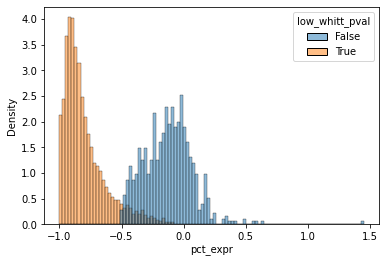

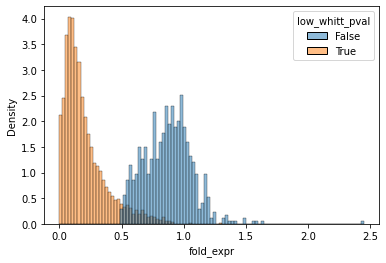

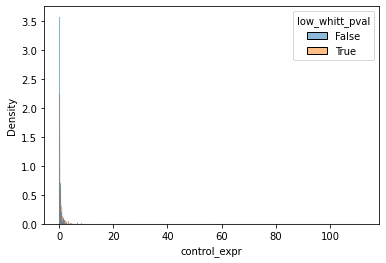

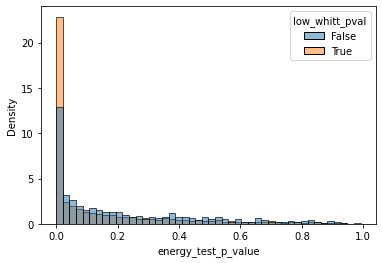

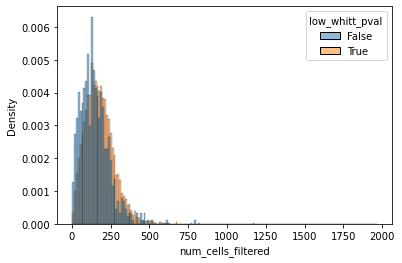

,Unnamed: 0,gene_ID,gene_transcript,gene,num_cells_filtered,control_expr,fold_expr,pct_expr,energy_test_p_value,correct_p_values,mann_whitney_counts,targeting sequence A,sgID_A,targeting sequence B,sgID_B,core_control,z_gemgroup_UMI,low_whitt_pval
0,0,ENSG00000131043,9_AAR2_P1P2_ENSG00000131043,AAR2,93.0,0.174746,0.0,-1.0,0.000100,1.698119e-03,377,GTGGGGCGAGGCGGTGAGTG,AAR2_-_34824434.23-P1P2,GGACTCTGAGCCGAGAAGAG,AAR2_+_34824488.23-P1P2,False,-0.288654,True
1,1,ENSG00000138030,4338_KHK_P1P2_ENSG00000138030,KHK,127.0,0.107530,0.0,-1.0,0.860014,5.077556e-03,0,GGGACACGCGAGGTACAGCT,KHK_+_27309661.23-P1P2,GCGACCGCGGGCTTCAGGCA,KHK_-_27309646.23-P1P2,False,0.092424,True
2,2,ENSG00000136051,4358_WASHC4_P1P2_ENSG00000136051,WASHC4,117.0,0.259725,0.0,-1.0,0.007299,1.189495e-03,9,GCAGCCCCAACCAGCCCGTG,KIAA1033_+_105501533.23-P1P2,GAGCGCTCCTGCGAGAGGGA,KIAA1033_-_105501728.23-P1P2,False,-0.108992,True
3,3,ENSG00000173214,4370_MFSD4B_P1P2_ENSG00000173214,MFSD4B,181.0,0.290107,0.0,-1.0,0.039096,4.315140e-12,13,GAGCGGACCGCCCGGAACCG,KIAA1919_+_111580599.23-P1P2,GCGGAACCGGGGCAGAGAAG,KIAA1919_+_111580588.23-P1P2,False,0.039041,True
4,4,ENSG00000081386,10407_ZNF510_P1P2_ENSG00000081386,ZNF510,42.0,0.134806,0.0,-1.0,0.521748,5.528555e-01,1,GGCACCAGCAAACACTAACA,ZNF510_-_99540354.23-P1P2,GTGCAGAGGGTTCGCAGCTC,ZNF510_+_99540314.23-P1P2,False,-0.005547,True


In [42]:
print ('Plot thresholding on mann-whitney p-vals OR have < -0.5% knockdown')
plot_table['low_whitt_pval'] = (plot_table['correct_p_values']<0.05) | (plot_table['pct_expr']<-0.5)
print('Number of significant genes given either of these metrics:')
print(sum(plot_table['low_whitt_pval']))
print(sum(plot_table['low_whitt_pval'])/len(plot_table))

for each in ['pct_expr','fold_expr','control_expr','energy_test_p_value','num_cells_filtered']:
    sns.histplot(x=each, hue = 'low_whitt_pval', data = plot_table, stat="density", common_norm=False)
    plt.show()

**Notes/Summary**
- In what could be termed an assertion of my previous concern from the last section of p-value plots, the graphs above give a better sense of what graphs we can truly trust because:
- Again, mapping statistical significance (based on the mann-whittney p-vals) to a couple  parameters doesn't fully add up:
    - **control_expr**: there seems to be a bias where cells with good knockdown are naturally highly expressed in the first place; so poor KD cells are more likely to not be as highly expressed
    - **energy test**: honestly the most concerning one because why do the statistically insignificant (high p-vals by way of the mann whitney) have such a high frequency of low p-values; the last thing they should be is inversely related.  
    - **fold_expr + pct+expr** have pretty much the same distribution (as expected) 
    - **pct_expr** looks good though, meaning that our mann-whitney p-vals do actually correspond with pct_expr; ideally, there should be a clear shift of the blue to the right such that the statistically insignificant actually correspond with high pct_expr which there is!
    - **mann-whitney p-vals** seem to be way more reliable than energy test, hence why the preceding graphs are based purely off of them.

# 7) Plotting features of genes with poor KD

Good KD genes with lowest p-values


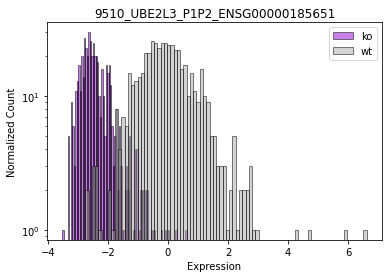

Number of cells with 9510_UBE2L3_P1P2_ENSG00000185651 (promoter-specific) perturbation: 520


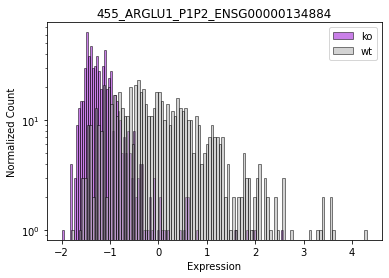

Number of cells with 455_ARGLU1_P1P2_ENSG00000134884 (promoter-specific) perturbation: 673


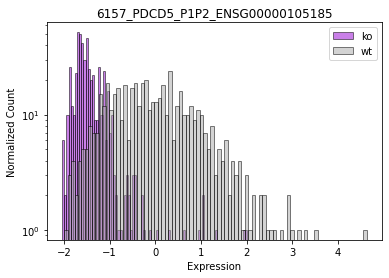

Number of cells with 6157_PDCD5_P1P2_ENSG00000105185 (promoter-specific) perturbation: 527


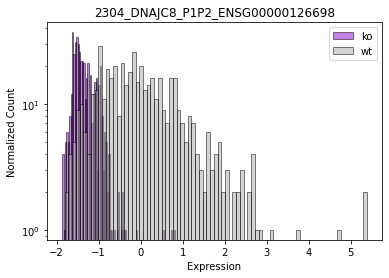

Number of cells with 2304_DNAJC8_P1P2_ENSG00000126698 (promoter-specific) perturbation: 488


<Figure size 432x288 with 0 Axes>

In [78]:
num = 4
good_kd = [transcript for transcript in plot_table.sort_values('correct_p_values', ascending = True)['gene_transcript']]

poor_kd = [transcript for transcript in plot_table.sort_values('correct_p_values', ascending = False)['gene_transcript']]

print("Good KD genes with lowest p-values")
for i, gene_transcript in enumerate(good_kd[0:num]):
    plot_hist_transcript(gene_transcript)
    
plt.tight_layout()

Poor KD genes with highest p-values


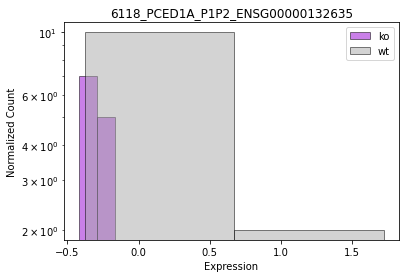

Number of cells with 6118_PCED1A_P1P2_ENSG00000132635 (promoter-specific) perturbation: 12


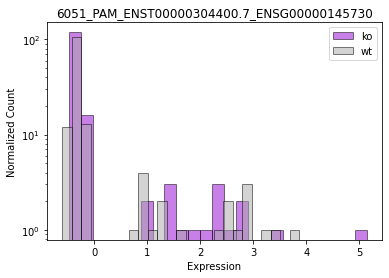

Number of cells with 6051_PAM_ENST00000304400.7_ENSG00000145730 (promoter-specific) perturbation: 151


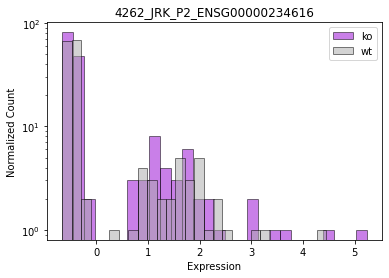

Number of cells with 4262_JRK_P2_ENSG00000234616 (promoter-specific) perturbation: 169


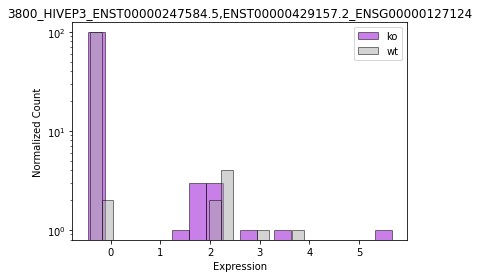

Number of cells with 3800_HIVEP3_ENST00000247584.5,ENST00000429157.2_ENSG00000127124 (promoter-specific) perturbation: 109


In [79]:
print("Poor KD genes with highest p-values")
for i, gene_transcript in enumerate(poor_kd[0:num]):
    plot_hist_transcript(gene_transcript)

In [82]:
print('Subsetting on target gene expression (whitt p-val) AND < -0.5% knockdown ')
plot_table['poor_KD'] = (plot_table['correct_p_values']>0.05) & (plot_table['pct_expr']>-0.5)
print('')

print(f"Number of transcripts with poor KD: {sum(plot_table['poor_KD'])}")
print(f"Number of genes with poor KD in at least one guide: {len(set(plot_table[plot_table['poor_KD']]['gene']))}")
genes_poor_KD = plot_table[plot_table['poor_KD'] == True]['gene']
genes_good_KD = plot_table[plot_table['poor_KD'] == False]['gene']

#poor KD genes that are also poor KD when targeted by another guide or at another promoter!
total_poor_KD = plot_table[plot_table['poor_KD'] == True][~genes_poor_KD.isin(genes_good_KD)]
print("")
print(f"Number of genes with poor KD across all guides used to target: {len(total_poor_KD)}")

Subsetting on target gene expression (whitt p-val) AND < -0.5% knockdown 

Number of transcripts with poor KD: 707
Number of genes with poor KD in at least one guide: 672

Number of genes with poor KD across all guides used to target: 380


In [20]:
plot_table = plot_table[['gene_ID','gene_transcript','gene','poor_KD','num_cells_filtered', 'control_expr',
 'fold_expr','pct_expr','energy_test_p_value','correct_p_values','mann_whitney_counts','targeting sequence A',
 'sgID_A','targeting sequence B','sgID_B','core_control','z_gemgroup_UMI']]

**Hidden graphs that can be displayed by running code below:**

In [ ]:
#Displays poor KD genes with highest number of cells filtered
print("Poor KD genes with highest number of cells filtered")
num = 4
num_cell_rank = total_poor_KD.sort_values('num_cells_filtered', ascending=False)
for i, gene in enumerate(num_cell_rank['gene'][0:num]):
    plot_hist(gene)
    
plt.tight_layout()

#Displays poor KD genes with highest levels of expression
print("Poor KD genes with highest levels of expression")
num = 4
control_expr_rank = total_poor_KD.sort_values('control_expr', ascending=False)
for i, gene in enumerate(control_expr_rank['gene'][0:num]):
    plot_hist(gene)
    
plt.tight_layout()

#Displays poor KD genes with most significant pct_expr
print("Poor KD genes with most significant pct_expr")
num = 4
pct_expr_rank = total_poor_KD.sort_values('pct_expr', ascending=False)
for i, gene in enumerate(pct_expr_rank['gene'][0:num]):
    plot_hist(gene)
    
plt.tight_layout()

troubleshoot:

In [ ]:
cols = list(plot_table.columns.values)

# 8) Importing and integrating DepMap CRISPRn and CRISPRi growth data

Why am I donig this? Great question! Because growth phenotypes can tell us so much more, especially given the decision to now stick with pct_expr and whitt_p_values as the most relevant metrics for filtering our data on!

In particular, genes that we see have good knockout when we use CRISPRn (regular CRISPR cutting) on them but poor knockdown when targeted by CRISPRi would definitely be particularly interesting to narrow in on so having this be part of our table helps to streamline our final list of curated genes!

In [51]:
crispri_growth_df = pd.read_excel('/lab/solexa_weissman/victory/gwps/CRISPRi_Growth_Phenotypes.xlsx')
crispri_growth_df = crispri_growth_df.rename(columns={'Unnamed: 0': 'gene', 'Unnamed: 2':'CTx-DTA phenotype (mean of top 3 rhos)','Unnamed: 4': 'CTx-DTA phenotype (mean of top 3 rhos)'})
crispri_growth_df = crispri_growth_df.drop(labels = 0)

/home/victory/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [118]:
crispri_sig = -0.05
crisprn_sig = -0.25

growth_phenotype_poorKD = pd.merge (total_poor_KD, crispri_growth_df, on = 'gene')
print("Percent of poor KD genes WITHOUT notable growth phenotype:",
      (len(growth_phenotype_poorKD[growth_phenotype_poorKD['CRISPRi']>= crispri_sig])/len(growth_phenotype_poorKD))*100)

# Initially used -0.2 for both thresholds but changed to -0.05 for CRISPRi and -0.5 for CRISPRn after 
# plotting distribution of genes across both metrics and arbitralily/visually determining where there was a fall-off

print("Number of poor KD genes WITH notable CRISPRi growth phenotype:",
      len(growth_phenotype_poorKD[growth_phenotype_poorKD['CRISPRi']<crispri_sig]))

growth_phenotype_poorKD['CRISPRi growth?'] = (growth_phenotype_poorKD['CRISPRi']<crispri_sig)

CRISPRn_growth_df = pd.read_csv('/lab/solexa_weissman/victory/gwps/CRISPR_gene_effect.csv')
k562_growth_df = CRISPRn_growth_df[CRISPRn_growth_df["DepMap_ID"]=='ACH-000551']

# k562 depmapID is #ACH-000551
k562_growth_df = k562_growth_df.transpose()
k562_growth_df = k562_growth_df.drop(labels = 'DepMap_ID')

k562_growth_df.to_csv('k562_CRISPRn_growth_df.csv')

growth_ID_list = []

for gene in k562_growth_df.index:
    gene_mutated = gene.split(" ")[0]
    growth_ID_list.append(gene_mutated)

growth_ID_list
k562_growth_df.index = growth_ID_list
k562_growth_df.index.name = 'gene'

growth_phenotype_poorKD = pd.merge (growth_phenotype_poorKD, k562_growth_df, on = 'gene')
growth_phenotype_poorKD.sort_values('control_expr', ascending = False)

growth_phenotype_poorKD = growth_phenotype_poorKD.rename(columns={354:'CRISPRn growth','Unnamed: 0':'index'})

print ("")
print ("Total number of poor KD genes with identifiable CRISPRn and CRISPRi growth phenotypes:", len(growth_phenotype_poorKD))
print ("(THIS IS THE SUBSET OF GENES WE ACTUALLY TRULLLLY CARE ABOUT AND WILL EXPORT", 
       "TO EXCEL FOR ANY FURTHER ANALYSIS!!)")

display (growth_phenotype_poorKD.head())

#why do we still have transcripts for genes with more than one promoter?

Percent of poor KD genes WITHOUT notable growth phenotype: 74.06340057636888
Number of poor KD genes WITH notable CRISPRi growth phenotype: 90

Total number of poor KD genes with identifiable CRISPRn and CRISPRi growth phenotypes: 347
(THIS IS THE SUBSET OF GENES WE ACTUALLY TRULLLLY CARE ABOUT AND WILL EXPORT TO EXCEL FOR ANY FURTHER ANALYSIS!!)


,index,gene_ID,gene_transcript,gene,num_cells_filtered,control_expr,fold_expr,pct_expr,energy_test_p_value,correct_p_values,...,core_control,z_gemgroup_UMI,low_whitt_pval,poor_KD,CRISPRi,CTx-DTA phenotype (mean of top 3 rhos),CRISPRa,CTx-DTA phenotype (mean of top 3 rhos),CRISPRi growth?,CRISPRn growth
0,6835,ENSG00000123411,4086_IKZF4_P2_ENSG00000123411,IKZF4,344.0,0.139745,0.503636,-0.496364,0.000400,0.050709,...,False,0.125833,False,True,-0.026218,0.042534,-0.02189,0.032956,False,-0.054305
1,7107,ENSG00000123411,4085_IKZF4_P1_ENSG00000123411,IKZF4,127.0,0.139745,0.597227,-0.402773,0.235976,0.453568,...,False,0.091944,False,True,-0.026218,0.042534,-0.02189,0.032956,False,-0.054305
2,6844,ENSG00000104312,7316_RIPK2_P1P2_ENSG00000104312,RIPK2,205.0,0.232268,0.506890,-0.493110,0.262574,0.106276,...,False,0.035750,False,True,0.016584,0.013989,-0.228727,0.144132,False,0.081774
3,6851,ENSG00000100109,8853_TFIP11_P1P2_ENSG00000100109,TFIP11,101.0,0.316886,0.509292,-0.490708,0.000300,0.054625,...,False,0.024513,False,True,-0.026098,0.023111,-0.010051,0.019008,False,-0.650149
4,6854,ENSG00000183207,7608_RUVBL2_P1P2_ENSG00000183207,RUVBL2,6.0,1.316451,0.510263,-0.489737,0.385061,0.131033,...,False,0.293544,False,True,-0.101806,-0.086952,-0.032357,0.001259,True,-1.890107


**Notes/Summary**
- Having the majority of poor KD genes with high CRISPRi growth phenotypes is a good sign; that's what we actually want to see!
- Poor KD genes went down from **380 to about 347** after adding CRISPRi and CRISPRn phenotype data because didn't have values for every single gene; focusing on the ones that did though helps increase our confidence level about the genes being actual poor_KD
While there are cases for the phenotypes where we have strange results like:
- notable CRISRPi growth phenotype but no CRISPRn_growth phenotype 
- notable growth phenotype for both CRISRPi and CRISRPn
we don't want to focus on those. 

**Instead, we narrowed in on:**
- genes with no CRISRPi growth phenotype but notable CRISPRn_growth phenotypes (first and foremost)
- more secondary but genes with neither CRISPRn or CRISPRi growth phenotype

This analysis was done in excel (linked as **gwps_poor_KD_genes_reference.xlsx**) where we also sorted by num_cells_filtered and control_expr because having high expression and a good number of cells to target a given gene will be super useful experimentally! 

**Excel color code at end of code.**

# Extra: adjusted energy test p-values (benjamini-hochberg)
Not necessary but in an effort to see if the energy test problem we were having earlier was a result of not being FDR-corrected, I performed a benjamini-hochberg p-value correction.

This wasn't super useful though because, in the end, the 40:60 percent ratio we saw earlier only dropped to about 30:70 percent which is a step in the right direction but not significant enough to again use the enery test results as one of our metrics for analysis. 

In [ ]:
energy_values_sorting = list (plot_table.energy_test_p_value)
energy_values_sorting.sort()
energy_values_sorting

rank = 1
len_p_values = len (plot_table)
energy_values_correct = {}
for p in energy_values_sorting:
    adj_value = p*len_p_values/rank
    rank += 1
    energy_values_correct[p] = adj_value
    
corrected_energy_list = []
for p in list (plot_table.energy_test_p_value):
    corrected_energy_list.append(energy_values_correct[p])

corrected_energy_list

plot_table['corrected_energy_test'] = corrected_energy_list

print('fraction of genes with signficant transcriptional phenotype:', sum(plot_table['corrected_energy_test']<0.05)/len(plot_table))
print('fraction of poor KD genes with signficant transcriptional phenotype:', sum((plot_table['correct_p_values']>0.05) & (plot_table['corrected_energy_test']<0.05))/sum(plot_table['correct_p_values'] > .05))
print('fraction of poor KD genes without signficant transcriptional phenotype:', sum((plot_table['correct_p_values']>0.05) & (plot_table['corrected_energy_test']>0.05))/sum(plot_table['correct_p_values'] > .05))

fraction of genes with signficant transcriptional phenotype: 0.4805370780980537
fraction of poor KD genes with signficant transcriptional phenotype: 0.3169601482854495
fraction of poor KD genes without signficant transcriptional phenotype: 0.6830398517145505


# Extra: misc

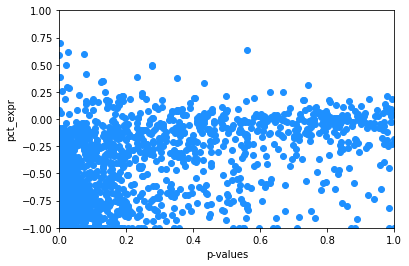

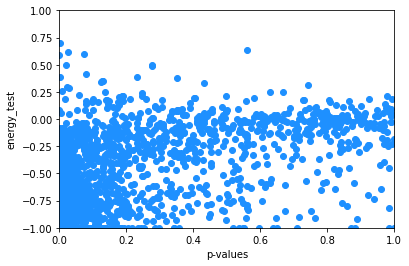

In [121]:
for each in ['pct_expr','energy_test']:
    plt.scatter (plot_table.correct_p_values,plot_table.pct_expr,marker = 'o', color = 'dodgerblue' )
    plt.xlabel('p-values')
    plt.ylabel(each)
    plt.xlim(0,1)
    plt.ylim(-1,1)
    
    plt.show()

**EXCEL SPREADSHEET OF CURATED GENES COLOR CODE**

- Everything highlighted in yellow covers genes without a CRISRPRi or CRISPRn growth phenotype
- Everything in orange covers genes without a CRISPRi growth phenotype but WITH a CRISRPn growth phenotype 
- Everything in green also falls under the same orange category but had transcripts read in a notable number of filtered cells and high control expression (I included anything with ctrl_expr at 0.8 or higher) which are great targets to test first!


# Potential Next Steps

- apply analysis to essentials in RPE-1 and K562
- check knockdown by separating out by guide
- perform tests on hand picked genes (in green and orange categories) to confirm recalcitrance to CRISPRi
- run ATAC-seq?
- qPCR validation?
- protein atlas?